# 0.6 Tensordot and Einsum

## Author: 

* Felix Hirwa Nshuti

This notebook demonstrates the use of `tensordot` and `einsum` functions to express complex tensor operations directly in terms of their mathimatical definitions. Instead of relying on multiple reshaping and transposing operations, these functions allows to specify how axes should be contracted, interacted, or aligned.

## A refresher on Tensor Operations

### What is a Tensor?

A tensor is a multi-dimensional array that generalizes the concepts of scalars (0D), vectors (1D), and matrices (2D) to higher dimensions. Tensors are used to represent data with multiple axes or dimensions, making them essential in fields like physics, computer science, and machine learning.

### Common Tensor Operations

1. **Reshaping**: Changing the shape of a tensor without altering its data.
2. **Transposing**: Rearranging the axes of a tensor.
3. **Slicing**: Extracting a subset of a tensor.
4. **Dot Product**: Generalizing matrix multiplication to higher dimensions.
5. **Element-wise Operations**: Performing operations on corresponding elements of tensors.

# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Shapes, Axes, and Broadcasting

- **Shapes**: The shape of a tensor is defined by the number of elements along each axis. For example, a tensor with shape (3, 4, 5) has 3 axes, with sizes 3, 4, and 5 respectively.
- **Axes**: Axes are the dimensions of a tensor. In a 3D tensor, axis 0 refers to the first dimension, axis 1 to the second, and axis 2 to the third.
- **Broadcasting**: Broadcasting is a technique that allows operations on tensors of different shapes by automatically expanding the smaller tensor along the missing dimensions to match the shape of the larger tensor.

`Numpy` and `PyTorch` handle the axes of different sizes that are compatible for arithmetic operations by broadcasting them to a common shape.

Two axes are compatible when:
1. They are equal, or
2. One of them is 1

If an axis is 1, it can be "stretched" to match the other axis during the operation.
Let's take an example to illustrate broadcasting:

A: a tensor of shape (4, 1, 6)
B: a tensor of shape (   5, 6)

Tensors are right-aligned for broadcasting and we compare axis from the rightmost side:

- 6 and 6 are equal, so they are compatible.
- 1 and 5 are compatible because one of them is 1. The axis with size 1 can be stretched to match the other dimension.
- Leading axis 4 in tensor A has no corresponding axis in tensor B, so it is retained as is.

The resulting shape after broadcasting will be (4, 5, 6).

## Relevance to Tensordot and Einsum
The `free indices` in the `tensordot` and `einsum` operations are subject to broadcasting rules. When performing these operations, the free indices of the resulting tensor must be compatible in shape according to broadcasting principles. Understanding broadcasting is crucial as it helps in predicting the shape of the output tensor and ensures that operations are performed correctly without shape mismatches.

You can refer to the following resources for more details on broadcasting:
- [Numpy Broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)


In [2]:
A = np.random.rand(4, 1, 6)
B = np.random.rand(5, 6)

A_shape = A.shape  # (4, 1, 6)
B_shape = B.shape  # (5, 6)

# broadcasting inside a numpy operation
C = A + B  # This will broadcast B to shape (4, 5, 6) before addition

broadcasted_shape = np.broadcast_shapes(A_shape, B_shape)

print("Shape of A:", A_shape)
print("Shape of B:", B_shape)
print(f"Broadcasted shape: {broadcasted_shape}, resulting shape of C: {C.shape}")


Shape of A: (4, 1, 6)
Shape of B: (5, 6)
Broadcasted shape: (4, 5, 6), resulting shape of C: (4, 5, 6)


# The logic of Contraction

Tensor contraction is a fundamental operation in tensor algebra that generalizes the concept of matrix multiplication to higher-dimensional tensors. 

Axes are divided into two categories during contraction:
1. **Contracted Axes**: These are the axes that are summed over during the contraction process. They are specified in the `tensordot` or `einsum` operation and are eliminated from the resulting tensor.
2. **Free Indices**: These are the axes that remain in the resulting tensor after the contraction. They are not summed over and define the shape of the output tensor.

$$
C_{ik} = \sum_{j} A_{ij}\,B_{jk}
$$

Here, j is the contracted axis; i and k are free indices. If A has shape (I, J) and B has shape (J, K), then C has shape (I, K).

The main idea is:
- Tensordot: You specify which axes to contract by their positions.
- Einsum: You label both contracted axes and free indices explicitly using subscripts.

# A motivation example

Before we jump into `tensordot` and `einsum`, let's consider a practical example where we want to compute the matrix multiplication of two tensors A and B.

Let $$\mathbf{A} \in \mathbb{R}^{(4, 3, 5)} $$ and $$\mathbf{B} \in \mathbb{R}^{(6, 5)}$$. And we want to compute the matrix multiplication along the last axis of A and the second axis of B to produce a new tensor C of shape (4, 3, 6).

Using a simple `matmul` function without reshaping will raise an error due to incompatible shapes.
To achieve this we would typically need to reshape and transpose the tensors to align the axes correctly before performing the multiplication. This process can be cumbersome and error-prone.

```python
# Pseudocode
A_reshaped = A.reshape(12, 5)  # Reshape A to (4*3, 5)
B_transposed = B.T  # Transpose B to (5, 6)
C_reshaped = np.matmul(A_reshaped, B_transposed)  # Resulting shape (12, 6)
C = C_reshaped.reshape(4, 3, 6)  # Reshape back to (4, 3, 6)
```

However, with `tensordot` and `einsum`, we can express this operation directly in terms of the mathematical definition without the need for reshaping or transposing.

In [3]:
mat_A = np.random.randn(3, 4, 5)
mat_B = np.random.randn(6, 5)

A_reshaped = mat_A.reshape(12, 5)  # (3*4, 5)
B_transposed = mat_B.T
C_reshaped = A_reshaped @ B_transposed  # (12, 6)
C = C_reshaped.reshape(3, 4, 6)  # (3, 4, 6)
print("Shape of mat_A:", mat_A.shape)
print("Shape of mat_B:", mat_B.shape)
print("Shape of C:", C.shape)

Shape of mat_A: (3, 4, 5)
Shape of mat_B: (6, 5)
Shape of C: (3, 4, 6)


# Tensordot and its Explicit Axis Contraction

The `tensordot` function bridges standart matrix multiplication and higher-dimensional tensor contractions by allowing you to specify which axes to contract over.

It's syntax is:
```python
tensordot(a, b, axes)
```
Where:
- `a` and `b` are the input tensors.
- `axes` can be an integer or a tuple of lists.
    - If an integer `n` is provided, it contracts the last `n` axes of `a` with the first `n` axes of `b`.
    - If a tuple of lists is provided, it specifies the exact axes to contract for each tensor.

We can now use `tensordot` to perform the matrix multiplication of tensors A and B directly:

```python
C = np.tensordot(A, B, axes=([2], [1]))  # Contracting last axis of A with second axis of B
```

From this we can see that we simply solved shape alignment issues with a single function call.

In [4]:
# Shape of mat_A: (3, 4, 5)
# Shape of mat_B: (6, 5)
C_tensor_dot = np.tensordot(mat_A, mat_B, axes=([2], [1]))
print("Shape of C using tensordot:", C_tensor_dot.shape)
assert np.allclose(C, C_tensor_dot), "Results from manual and tensordot do not match!"
print("Results from manual and tensordot match!")

Shape of C using tensordot: (3, 4, 6)
Results from manual and tensordot match!


# Einsum: The Domain Specific Language for Tensor Operations

Einsum, short for Einstein summation convention, is a powerful and flexible function that allows you to express complex tensor operations using a concise notation. It generalizes many common tensor operations, including matrix multiplication, outer products, and transpositions.

Unlike `tensordot`, which requires you to specify axes by their positions, and this becomes a problem when the tensor rank changes. Einsum allows you to label both contracted axes and free indices explicitly using subscripts.

Its syntax is:
```python
einsum('input_subscripts->output_subscripts', *operands)
```
Where:
- `input_subscripts` Left side of the Arrow: is a string that specifies the subscripts for each input tensor.
- `output_subscripts` Right side of the Arrow: is a string that specifies the subscripts for the output tensor.
- `operands` are the input tensors.


### The three rules to remember when using `einsum` 

1. **Alignment (Repeated index across inputs)**
   If an index appears in more than one input tensor, the corresponding axes are **aligned and multiplied element-wise**.

2. **Summation (Index missing from output)**
   If an index appears in the input(s) but **not** in the output expression, the operation **sums over that axis**.

3. **Free index (Index present in output)**
   If an index appears in the input and is **also present** in the output expression, that axis is **preserved in the result** (no summation).

Back to our previous alignment problem we can solve it using `einsum` as follows:

- Step 1: Label the axes of A and B:
    - A has shape (4, 3, 5) → label as 'ijk' (i=4, j=3, k=5)
    - B has shape (6, 5) → label as 'lm' (l=6, m=5)

- Step 2: Identify alignments:
    - The last axis of A (k=5) aligns with the second axis of B (m=5). We can now give them the same label, say 'k'. Now we have:
        - A: 'ijk'
        - B: 'lk' (where m is replaced by k)

- Step 3: Define output labels:
    - The output tensor C will have the free indices from A (i=4, j=3) and B (l=6). So we label the output as 'ijl'.

```python
C = np.einsum('ijk,lk->ijl', A, B) # gives C of shape (4, 3, 6)
```
This single line of code performs the desired matrix multiplication while correctly handling the alignment of axes.

In [5]:
# Shape of mat_A: (3, 4, 5)
# Shape of mat_B: (6, 5)
C_einsum = np.einsum('ijk,lk->ijl', mat_A, mat_B)
print("Shape of C using einsum:", C_einsum.shape)
assert np.allclose(C, C_einsum), "Results from manual and einsum do not match!"
print("Results from manual and einsum match!")

Shape of C using einsum: (3, 4, 6)
Results from manual and einsum match!


# Common Patterns: Examples of Einsum and Tensordot

To build intuition on how to read and write `einsum` and `tensordot` expressions, let's explore some common tensor operations.

## Vector Operations

We have 1D input vectors defined as:
$$\mathbf{a} \in \mathbb{R}^{(N)} $$ and $$ \mathbf{b} \in \mathbb{R}^{(N)} $$

### Dot Product
The dot product is defined as:
$$
\mathbf{c} = \sum_{i=1}^{N} a_i b_i
$$

In [6]:
a = np.random.rand(3)
b = np.random.rand(3)
gt_result = np.dot(a, b)
print("Ground truth dot product:", gt_result)

tensor_dot_result = np.tensordot(a, b, axes=1) # contract over the only axis
print("Tensordot dot product:", tensor_dot_result)

# i appears in both inputs -> multiplied element-wise
# i appears in inputs but not in output -> summed over
einsum_result = np.einsum('i,i->', a, b)
print("Einsum dot product:", einsum_result)
assert np.allclose(gt_result, tensor_dot_result), "Tensordot result does not match ground truth!"
assert np.allclose(gt_result, einsum_result), "Einsum result does not match ground truth!"
print("Dot product results match ground truth!")

Ground truth dot product: 0.253459319152074
Tensordot dot product: 0.253459319152074
Einsum dot product: 0.253459319152074
Dot product results match ground truth!


### Outer Product
The outer product of two vectors $u$ (size $m$) and $v$ (size $n$) results in an $m \times n$ matrix C defined as:
$$
C_{ij} = u_i v_j
$$

Where i indexes the rows and j indexes the columns.

In [7]:
gt_outer = np.outer(a, b)
print("Ground truth outer product:\n", gt_outer)
tensor_dot_outer = np.tensordot(a, b, axes=0)  # no contraction
print("Tensordot outer product:\n", tensor_dot_outer)
# i appears in input a but not in input b -> new axis in output
einsum_outer = np.einsum('i,j->ij', a, b)  # no contraction
print("Einsum outer product:\n", einsum_outer)
assert np.allclose(gt_outer, tensor_dot_outer), "Tensordot outer product does not match ground truth!"
assert np.allclose(gt_outer, einsum_outer), "Einsum outer product does not match ground truth!"
print("Outer product results match ground truth!")

Ground truth outer product:
 [[0.15346547 0.43714609 0.11814448]
 [0.00375707 0.01070202 0.00289236]
 [0.11598691 0.33038851 0.08929184]]
Tensordot outer product:
 [[0.15346547 0.43714609 0.11814448]
 [0.00375707 0.01070202 0.00289236]
 [0.11598691 0.33038851 0.08929184]]
Einsum outer product:
 [[0.15346547 0.43714609 0.11814448]
 [0.00375707 0.01070202 0.00289236]
 [0.11598691 0.33038851 0.08929184]]
Outer product results match ground truth!


### Sum of elements (Sum Reduction)
Taking a vector `a` we can define the sum of its elements as:
$$
\mathbf{s} = \sum_{i=1}^{N} a_i
$$

In [8]:
gt_sum = np.sum(a)
print("Ground truth sum:", gt_sum)
tensor_dot_sum = np.tensordot(a, np.ones_like(a), axes=1)  # sum over the only axis
print("Tensordot sum:", tensor_dot_sum)
einsum_sum = np.einsum('i->', a)  # sum over i
print("Einsum sum:", einsum_sum)
assert np.allclose(gt_sum, tensor_dot_sum), "Tensordot sum does not match ground truth!"
assert np.allclose(gt_sum, einsum_sum), "Einsum sum does not match ground truth!"
print("Sum results match ground truth!")

Ground truth sum: 1.2062452490694195
Tensordot sum: 1.2062452490694195
Einsum sum: 1.2062452490694193
Sum results match ground truth!


### Element-wise Multiplication
The element-wise multiplication of two vectors `a` and `b` is defined as:
$$
c_i = a_i b_i
$$

In [9]:
elwise_mul_gt = a * b
print("Ground truth element-wise multiplication:", elwise_mul_gt)
elwise_mul_tensordot = np.tensordot(a, b, axes=0).diagonal() # using diagonal to extract element-wise products
print("Tensordot element-wise multiplication:", elwise_mul_tensordot)
# i appears in both inputs -> multiplied element-wise
elwise_mul_einsum = np.einsum('i,i->i', a, b)  # element-wise multiplication
print("Einsum element-wise multiplication:", elwise_mul_einsum)
assert np.allclose(elwise_mul_gt, elwise_mul_tensordot), "Tensordot element-wise multiplication does not match ground truth!"
assert np.allclose(elwise_mul_gt, elwise_mul_einsum), "Einsum element-wise multiplication does not match ground truth!"
print("Element-wise multiplication results match ground truth!")

Ground truth element-wise multiplication: [0.15346547 0.01070202 0.08929184]
Tensordot element-wise multiplication: [0.15346547 0.01070202 0.08929184]
Einsum element-wise multiplication: [0.15346547 0.01070202 0.08929184]
Element-wise multiplication results match ground truth!


## Matrix Operations

We have 2D input matrices defined as:
$$\mathbf{A} \in \mathbb{R}^{(M, N)} $$ and $$ \mathbf{B} \in \mathbb{R}^{(N, P)} $$

In [10]:
A = np.random.rand(4, 5)
B = np.random.rand(5, 6)
print("Shape of A:", A.shape)
print("Shape of B:", B.shape)

Shape of A: (4, 5)
Shape of B: (5, 6)


### Matrix Transpose
The transpose of a matrix A is defined as:
$$
C_{ij} = A_{ji}
$$

In [11]:
gt_AT = A.T
print("Shape of ground truth transpose:", gt_AT.shape)
einsum_AT = np.einsum('ij->ji', A)
print("Shape of einsum transpose:", einsum_AT.shape)
assert np.allclose(gt_AT, einsum_AT), "Einsum transpose does not match ground truth!"
print("Transpose results match ground truth!")

Shape of ground truth transpose: (5, 4)
Shape of einsum transpose: (5, 4)
Transpose results match ground truth!


### Trace of a Matrix
The trace of a square matrix A is defined as the sum of its diagonal elements:
$$
\text{trace}(A) = \sum_i A_{ii}
$$

In [12]:
C_ = np.random.rand(4, 4)
gt_trace = np.trace(C_)
print("Ground truth trace:", gt_trace)
trace_einsum = np.einsum('ii->', C_)
print("Einsum trace:", trace_einsum)
assert np.allclose(gt_trace, trace_einsum), "Einsum trace does not match ground truth!"
print("Trace results match ground truth!")

Ground truth trace: 2.710348587301081
Einsum trace: 2.710348587301081
Trace results match ground truth!


### Diagonal Extraction
The diagonal extraction of a square matrix A results in a vector d defined as:
$$
d_i = A_{ii}
$$

In [13]:
gt_diag = np.diagonal(C_)
print("Ground truth diagonal extraction:", gt_diag)
diag_einsum = np.einsum('ii->i', C_)
print("Einsum diagonal extraction:", diag_einsum)
assert np.allclose(gt_diag, diag_einsum), "Einsum diagonal extraction does not match ground truth!"
print("Diagonal extraction results match ground truth!")

Ground truth diagonal extraction: [0.97301055 0.50263709 0.28077236 0.95392858]
Einsum diagonal extraction: [0.97301055 0.50263709 0.28077236 0.95392858]
Diagonal extraction results match ground truth!


### Sum along an axis
The sum of a matrix A along axis 0 (columns) results in a vector s defined as:
$$
s_j = \sum_{i} A_{ij}
$$

Summing A along axis 1 (rows) results in a vector s defined as:
$$
s_i = \sum_{j} A_{ij}
$$

Summing all elements results in a scalar:
$$
s = \sum_{i} \sum_{j} A_{ij}
$$

In [14]:
gt_sum_axis0 = np.sum(C_, axis=0)
print("Ground truth sum over axis 0:", gt_sum_axis0)
sum_einsum_axis0 = np.einsum('ij->j', C_)
print("Einsum sum over axis 0:", sum_einsum_axis0)
assert np.allclose(gt_sum_axis0, sum_einsum_axis0), "Einsum sum over axis 0 does not match ground truth!"
print("Sum over axis 0 results match ground truth!")

gt_sum_axis1 = np.sum(C_, axis=1)
print("Ground truth sum over axis 1:", gt_sum_axis1)
sum_einsum_axis1 = np.einsum('ij->i', C_)
print("Einsum sum over axis 1:", sum_einsum_axis1)
assert np.allclose(gt_sum_axis1, sum_einsum_axis1), "Einsum sum over axis 1 does not match ground truth!"
print("Sum over axis 1 results match ground truth!")

# summing all elements
gt_sum_all = np.sum(C_)
print("Ground truth sum of all elements:", gt_sum_all)
sum_einsum_all = np.einsum('ij->', C_)
print("Einsum sum of all elements:", sum_einsum_all)

Ground truth sum over axis 0: [2.60853714 1.79529761 2.69018139 2.10190086]
Einsum sum over axis 0: [2.60853714 1.79529761 2.69018139 2.10190086]
Sum over axis 0 results match ground truth!
Ground truth sum over axis 1: [2.88929346 2.36686998 1.22278343 2.71697014]
Einsum sum over axis 1: [2.88929346 2.36686998 1.22278343 2.71697014]
Sum over axis 1 results match ground truth!
Ground truth sum of all elements: 9.195917004287224
Einsum sum of all elements: 9.195917004287224


### Matrix Multiplication
For a standard row-by-column matrix multiplication of two matrices A and B  is defined as:
$$
C_{ik} = \sum_{j} A_{ij}\,B_{jk}
$$

In [15]:
C_matrix_mul = A @ B
print("Shape of C using matrix multiplication:", C_matrix_mul.shape)
C_einsum_mul = np.einsum('ij,jk->ik', A, B)
print("Shape of C using einsum multiplication:", C_einsum_mul.shape)
assert np.allclose(C_matrix_mul, C_einsum_mul), "Einsum matrix multiplication does not match ground truth!"
print("Matrix multiplication results match ground truth!")

Shape of C using matrix multiplication: (4, 6)
Shape of C using einsum multiplication: (4, 6)
Matrix multiplication results match ground truth!


### Batch Matrix Multiplication
Now `einsum` is in it's shining glory, suppose we have a batch of matrices (e.g., 10 matrices of size 4x5) represented as a 3D tensor A of shape (10, 4, 5) and we want to multiply them by another batch of matrices B of shape (10, 5, 6) to produce a new batch of matrices C of shape (10, 4, 6).
$$
C_{bik} = \sum_{j} A_{bij}\,B_{bjk}
$$
Where b indexes the batch dimension, i indexes the rows, j indexes the shared dimension, and k indexes the columns of the resulting matrices.

libraries like torch generally use `bmm` for batch matrix multiplication but `einsum` can also handle this elegantly.

In [16]:
A = np.random.rand(10, 4, 5)
B = np.random.rand(10, 5, 6)
print("Shape of A (batch of matrices):", A.shape)
print("Shape of B (batch of matrices):", B.shape)
C_batch_mul = np.matmul(A, B)
print("Shape of C using batch matrix multiplication:", C_batch_mul.shape)
C_einsum_batch = np.einsum('bij,bjk->bik', A, B)
print("Shape of C using einsum batch multiplication:", C_einsum_batch.shape)
assert np.allclose(C_batch_mul, C_einsum_batch), "Einsum batch matrix multiplication does not match ground truth!"
print("Batch matrix multiplication results match ground truth!")

Shape of A (batch of matrices): (10, 4, 5)
Shape of B (batch of matrices): (10, 5, 6)
Shape of C using batch matrix multiplication: (10, 4, 6)
Shape of C using einsum batch multiplication: (10, 4, 6)
Batch matrix multiplication results match ground truth!


## Practical Examples

### Channel Mixing in Deep Learning

If we have a task of applying a linear transformation across the channel dimension of a batch of images we can use a (1x1 convolution).

We have a batch of RGB images and we want to convert the 3 color channels to 16 features using a weight matrix W of shape (3, 16).

Shapes:
- By using standard Numpy/ TensorFlow conventions, the input tensor X representing a batch of images would typically have the shape (batch_size, height, width, channels), which in this case is (32, 64, 64, 3).
- The weight matrix W would have the shape (channels, output_features), which is (3, 16) in this case.

The goal is for every single pixel (across all images in the batch) to be transformed from a 3-dimensional RGB vector to a 16-dimensional feature vector.
The output tensor Y will have the shape (32, 64, 64, 16).

The mathematical operation for a single pixel's output channel k can be expressed as:

$$
Y_{b,h,w,k} = \sum_{c=1}^{3} X_{b,h,w,c} \cdot W_{c,k}
$$

```python
Y = X @ W  # Shape: (32, 64, 64, 16)
```
This works in a standard setup as numpy treats the leading dimensions (batch_size, height, width) as free indices and applies the matrix multiplication across the last dimension (channels).

But in practice, forexample PyTorch, the data format changes and is ordered in the channels-first format: (batch_size, channels, height, width).

``X_torch`` is now of shape (32, 3, 64, 64) and we need to adjust our operation accordingly.
```python
Y = X_torch @ W  # This will raise an error due to shape mismatch
```
This gives extra work to align the shapes correctly.

We can first use `tensordot` and illustrate how it is a robust solution for now:
```python
Y_tensordot = np.tensordot(X_torch, W, axes=([1], [0]))  # Contracting channel axis of X with first axis of W
# Resulting shape will be (32, 64, 64, 16)
```

This works but still one key data format issue remains, the output shape is (32, 64, 64, 16) instead of (32, 16, 64, 64). We can fix this by transposing the output:
```python
Y_tensordot = np.transpose(Y_tensordot, (0, 3, 1, 2))  # Rearranging axes to (batch_size, output_features, height, width)
```

Now you see we still face issue of transposition and manually tracking axes. A savior comes in form of `einsum`:
```python
Y_einsum = np.einsum('bchw,ck->bkhw', X_torch, W)  # Directly specifying the desired output shape
```

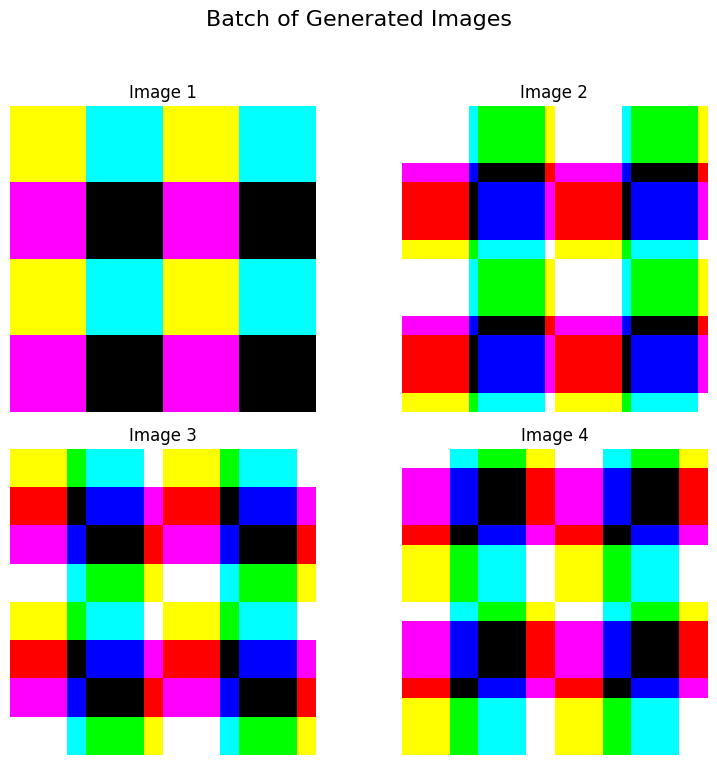

In [17]:
def create_batch(batch_size, height, width, grid_size=16):
    """Creates a batch of visually distinct images."""
    batch_images = []
    for i in range(batch_size):
        y, x = np.indices((height, width))
        
        offset = i * (grid_size // 4)

        # Red Vertical stripes with a shift
        r_mask = ((x + offset // 2) // grid_size % 2 == 0).astype(np.float32)
        
        # Green Horizontal stripes with a different shift
        g_mask = ((y + offset) // grid_size % 2 == 0).astype(np.float32)
        
        # Blue A checkerboard pattern that also changes
        b_mask = (((x // grid_size) + (y // grid_size) + i) % 2 == 1).astype(np.float32)
        
        # Shape (Height, Width, 3)
        img = np.stack([r_mask, g_mask, b_mask], axis=-1)
        batch_images.append(img)
        
    return np.stack(batch_images, axis=0)

images = create_batch(batch_size=4, height=64, width=64, grid_size=16)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Batch of Generated Images', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
# Transpose from (Batch, Height, Width, Channels) to (Batch, Channels, Height, Width)
images_channel_first = np.transpose(images, (0, 3, 1, 2))
images_channel_first.shape

(4, 3, 64, 64)

In [19]:
input_channels = 3
output_features = 16
W = np.random.randn(input_channels, output_features)
print(f"Input shape: {images_channel_first.shape}")
print(f"Weight shape: {W.shape}")

Input shape: (4, 3, 64, 64)
Weight shape: (3, 16)


Output shape: (4, 16, 64, 64)


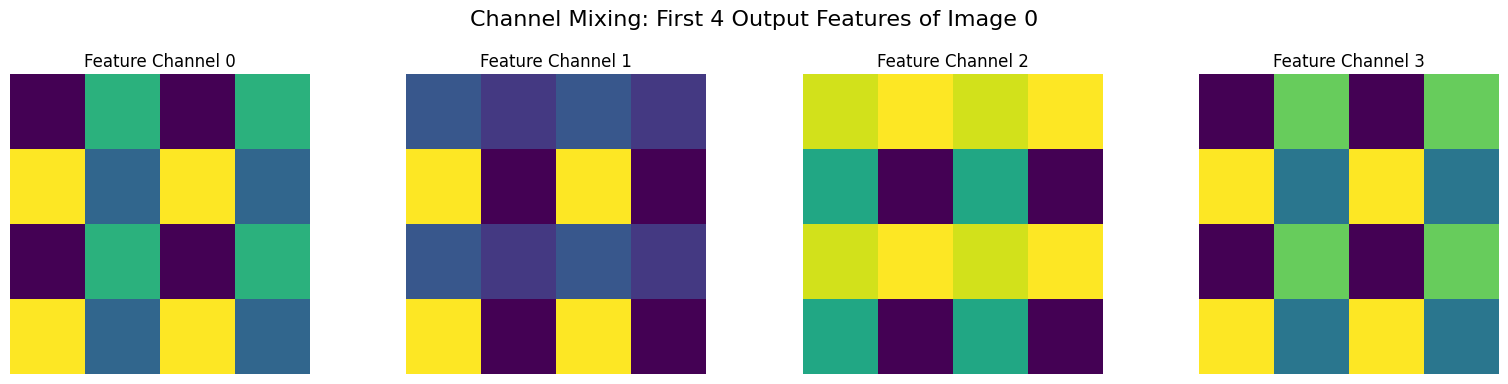

In [20]:
mixed_output = np.einsum('bchw,ck->bkhw', images_channel_first, W)
print(f"Output shape: {mixed_output.shape}")

single_image = mixed_output[0]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Channel Mixing: First 4 Output Features of Image 0', fontsize=16)

channels_to_plot = [0, 1, 2, 3]

for i, channel_idx in enumerate(channels_to_plot):
    ax = axes[i]
    feature_map = single_image[channel_idx, :, :]
    
    ax.imshow(feature_map, cmap='viridis')
    ax.set_title(f"Feature Channel {channel_idx}")
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Shape of image batch: (4, 3, 64, 64)
Shape of filters: (3,)
Shape of grayscale images: (4, 64, 64)


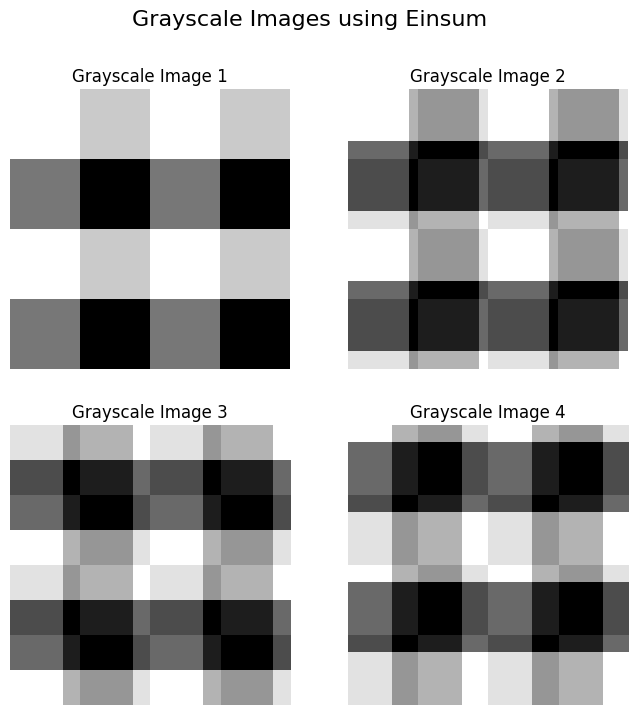

In [21]:
W_gray  = np.array([0.299, 0.587, 0.114])

print("Shape of image batch:", images_channel_first.shape)

print("Shape of filters:", W_gray.shape)

gray_scale_images = np.einsum('bchw,c->bhw', images_channel_first, W_gray)

print("Shape of grayscale images:", gray_scale_images.shape)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

fig.suptitle('Grayscale Images using Einsum', fontsize=16)

for i, ax in enumerate(axes.flat):

    if i < len(gray_scale_images):

        ax.imshow(gray_scale_images[i], cmap='gray')

        ax.set_title(f"Grayscale Image {i+1}")

    ax.axis('off')

### Spatial Convolution (Blurring an Image)

Unlike channel mixing, spatial convolution involves mixing pixels with their neighbors.

With only `einsum`, we cannot easily express spatial convolution since it requires accessing neighboring pixels, which is beyond the capabilities of `einsum` alone.

We can borrow some cool tricks that involves Unfolding/Im2col techniques to express spatial convolution using `einsum`.

We can achieve this by unfolding (transform image from (B, C, H, W) to a shape that exposes all local patches) and then applying `einsum` to perform the convolution operation.

```python
# pseudocode
input: images: (Batch, Channels, Height, Width)
kernel_size: (kH, kW)
windows: extract local patches from images  # shape: (Batch, Channels, out_H, out_W, kH, kW)
output: np.einsum('bchwij,coij->bhow', windows, filters)  # shape: (Batch, out_Channels, out_H, out_W)
```

Shape of input images with channel axis: (4, 1, 64, 64)
Shape of sliding windows: (4, 1, 62, 62, 3, 3)
Shape of blurred images: (4, 1, 62, 62)


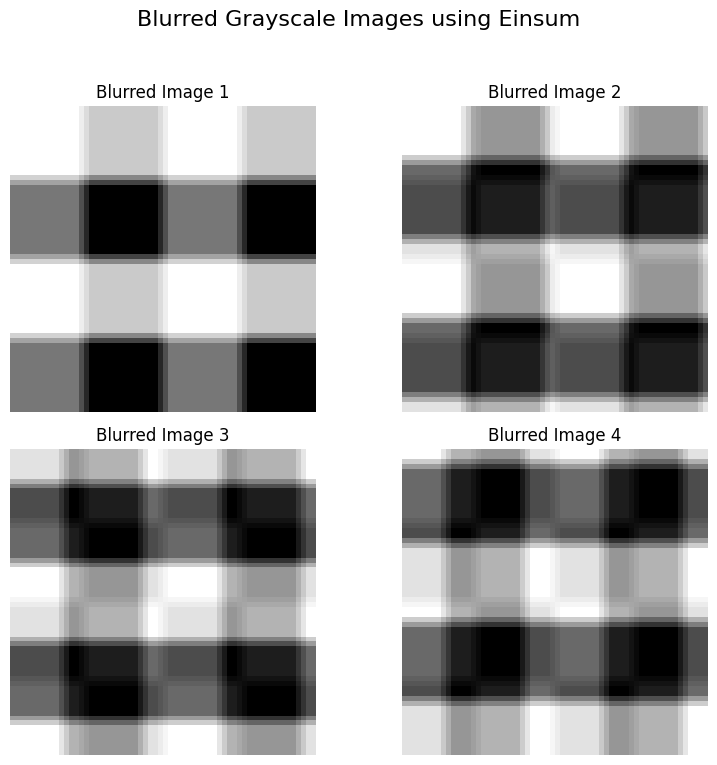

In [22]:
# use gray_scale_images
from numpy.lib.stride_tricks import sliding_window_view

# Reshape grayscale images to include a channel dimension: (4, 64, 64) -> (4, 1, 64, 64)
input_images = gray_scale_images[:, np.newaxis, :, :]
print("Shape of input images with channel axis:", input_images.shape)

kernel = np.ones((3, 3))/9.0 # average blur

# Now axis=(2, 3) is valid for the 4D input tensor (height and width axes)
windows = sliding_window_view(input_images, window_shape=(3, 3), axis=(2, 3))
print("Shape of sliding windows:", windows.shape)

# Einsum performs the convolution: sums over the kernel dimensions (xy) for each window
# 'bchwxy,xy->bchw'
# b: batch, c: channels, h: height, w: width, x,y: kernel dimensions
blurred_images = np.einsum('bchwxy,xy->bchw', windows, kernel)
print("Shape of blurred images:", blurred_images.shape)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Blurred Grayscale Images using Einsum', fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < len(blurred_images):
        # Squeeze the channel dimension for plotting
        ax.imshow(np.squeeze(blurred_images[i]), cmap='gray')
        ax.set_title(f"Blurred Image {i+1}")
    ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Shape of blurred RGB images: (4, 3, 62, 62)


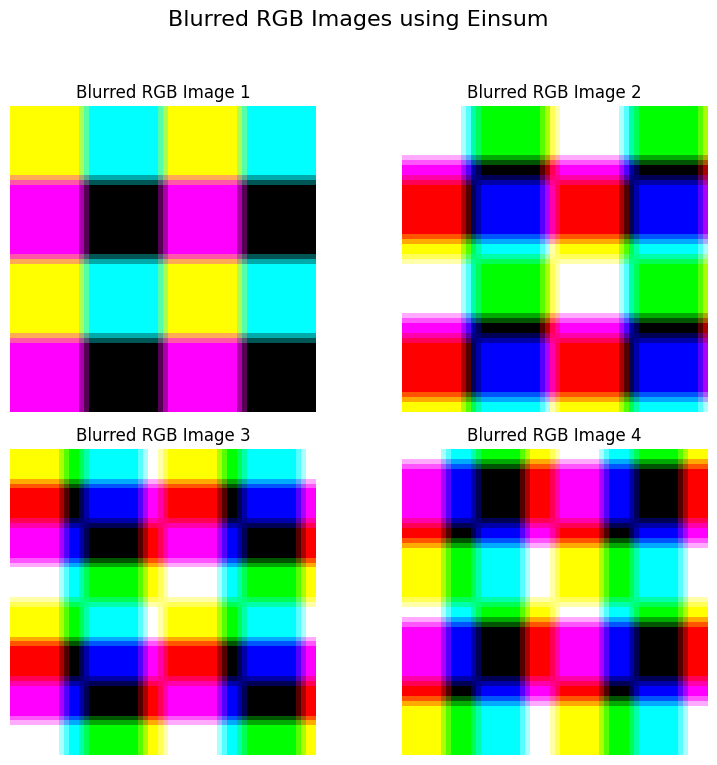

In [23]:
# For original RGB images
input_images = images_channel_first
kernel = np.ones((3, 3))/9.0 # average blur

windows = sliding_window_view(input_images, window_shape=(3, 3), axis=(2, 3))

blurred = np.einsum('bchwxy ,xy ->bchw', windows , kernel)

print("Shape of blurred RGB images:", blurred.shape)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Blurred RGB Images using Einsum', fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < len(blurred):
        # Transpose back to (Height, Width, Channels) for plotting
        img_to_show = np.transpose(blurred[i], (1, 2, 0))
        ax.imshow(np.clip(img_to_show, 0, 1))
        ax.set_title(f"Blurred RGB Image {i+1}")
    ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Using a standard approach would require a lot of work, we would need to flatten spatial stucture

Shape of result using standard approach: (4, 3, 62, 62)


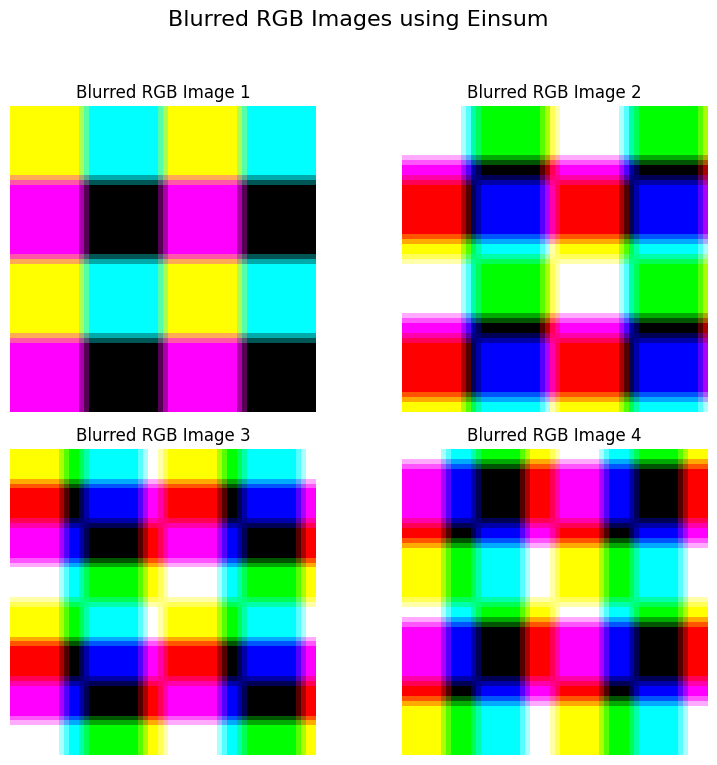

In [24]:
k_flat = kernel.flatten()
w_flat = windows.reshape(*windows.shape[:-2], -1)
result_blur = w_flat @ k_flat

print("Shape of result using standard approach:", result_blur.shape)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Blurred RGB Images using Einsum', fontsize=16)
for i, ax in enumerate(axes.flat):
    if i < len(result_blur):
        # Transpose back to (Height, Width, Channels) for plotting
        img_to_show = np.transpose(result_blur[i], (1, 2, 0))
        ax.imshow(np.clip(img_to_show, 0, 1))
        ax.set_title(f"Blurred RGB Image {i+1}")
    ax.axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Performance Insights and Best Practices

When working with `tensordot` and `einsum`, it's important to understand their performance implications and follow best practices to write efficient and readable code.

## Performance Insights

1.  **Reduced Memory Overhead**: `einsum` and `tensordot` can be significantly more memory-efficient than manual operations. When you perform a series of transpositions, reshapes, and multiplications, NumPy may create intermediate copies of your arrays in memory. `einsum` can often compute the final result in a single pass, avoiding these temporary arrays and reducing memory consumption.

2.  **Optimized Contractions**: `einsum` is not just a convenient notation; it's a highly optimized function. For contractions involving three or more tensors, `einsum` can analyze the expression to determine the most efficient order of operations (the "contraction path"). This can lead to dramatic performance improvements by minimizing the size of intermediate arrays. You can control this with the `optimize` argument (e.g., `np.einsum(..., optimize='greedy')`).

3.  **Underlying BLAS/LAPACK Libraries**: For many common operations (like matrix multiplication), `einsum` can delegate the computation to highly optimized, low-level libraries like BLAS and LAPACK, ensuring near-native performance.

4.  **`tensordot` vs. `einsum`**: For contracting just two tensors, `tensordot` and `einsum` often have comparable performance. However, `einsum`'s flexibility makes it the clear choice for more complex operations involving multiple tensors or intricate index manipulations.

## Best Practices

1.  **Use the Right Tool for the Job**:
    *   For simple, standard operations like matrix multiplication (`A @ B`), vector dot products (`np.dot(u, v)`), or transposing (`A.T`), use the dedicated NumPy functions or operators. They are idiomatic and more readable for those unfamiliar with `einsum`.
    *   Use `tensordot` when you need to contract specific axes between two tensors and find its syntax (`axes=([1],[0])`) clearer than `einsum`'s subscript notation.
    *   Use `einsum` for complex operations that would otherwise require multiple steps (reshaping, transposing, multiplying). It shines in cases like batch operations, channel mixing, and multi-tensor contractions.

2.  **Prioritize Readability**: While `einsum` is powerful, its subscript notation can be cryptic. Add comments to your `einsum` expressions explaining what the indices mean and what the operation is achieving, just as we did in this notebook (e.g., `'bchw,c->bhw'`).

3.  **Profile Your Code**: Don't assume `einsum` is always faster. For your specific use case, use notebook magics like `%timeit` to compare the performance of an `einsum` expression against a more conventional approach. The results can sometimes be surprising depending on the tensor shapes and the complexity of the operation.

4.  **Leverage the `optimize` Argument**: When contracting three or more tensors with `einsum`, always consider using the `optimize` parameter. The default is often conservative, and explicitly setting it (e.g., `optimize='optimal'` or `optimize='greedy'`) can provide substantial speedups by finding a better contraction path.

By following these guidelines, you can write tensor code that is not only correct and efficient but also clear and maintainable.

# Conclusion

Throughout this notebook, we have explored the power and elegance of `tensordot` and `einsum` for performing complex tensor operations. We started with the fundamental concepts of tensor contraction and broadcasting and progressively built up to practical examples in deep learning, such as channel mixing and spatial convolution.

The key takeaways are:

- **Expressiveness**: `tensordot` and `einsum` allow you to express tensor operations directly in terms of their mathematical definitions. This often leads to code that is more concise and closer to the underlying mathematical intent than solutions involving multiple manual `reshape` and `transpose` calls.

- **Flexibility**: `einsum` stands out as a "domain-specific language" for tensor operations. Its subscript notation provides a unified syntax for a vast range of operations, from simple vector products to complex batch operations, making it an invaluable tool for any practitioner working with multi-dimensional data.

- **Performance**: By avoiding the creation of intermediate arrays and leveraging optimized backend libraries, these functions can offer significant performance and memory advantages over manual, multi-step approaches.

- **Bridging Theory and Practice**: By using these tools, you can more easily translate the mathematical formulas found in research papers and textbooks directly into executable code, reducing the potential for bugs and making your implementations more verifiable.

Mastering `tensordot` and especially `einsum` is a valuable skill that can simplify your code, improve its performance, and deepen your understanding of tensor manipulations in scientific computing and deep learning.

## Further Reading

- [NumPy einsum Documentation](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html)
- [NumPy tensordot Documentation](https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html)
- [An Intro to Einsum and Jax Transformers](https://huggingface.co/blog/dejavucoder/einsum)
- [Einsum is All you Need - Einstein Summation in Deep Learning](https://rockt.ai/2018/04/30/einsum)
- [Tensordot and einsum recitation Fall 2025 - Youtube](https://www.youtube.com/watch?v=uOXd5-uunP0)